In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
from torchvision import transforms
from net import Net
from dataset import get_caption_dataset
%matplotlib inline

In [2]:
batch_size = 8
image_size = 224

hidden_dim = 512
attn_dim   = 512
num_layers = 1

max_vocab = 10000

data_root = "./data"
ckpt_path = "./checkpoint/caption_129000.pth"

In [3]:
def inverse_transform(image):
    transform = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    image = image.clone()
    image = transform(image).mul(255).clamp_(0, 255)
    
    return image.byte().permute(1, 2, 0).cpu().numpy()

In [4]:
# to initialize vocab
_, _, TEXT = get_caption_dataset(
    train=True,
    max_vocab=max_vocab,
    data_root=data_root,
    batch_size=batch_size, 
    image_size=image_size,
    num_workers=1,
    text_field=True)
loader, dataset = get_caption_dataset(
    train=False,
    data_root=data_root,
    batch_size=batch_size,
    num_workers=1,
    image_size=image_size)

[!] Prepare COCO train dataset
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
[!] Dataset preparation done!
	# of data: 414113
	Vocab size: 10004

[!] Prepare COCO val dataset
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
[!] Dataset preparation done!
	# of data: 202654
	Vocab size: 10004



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(TEXT, hidden_dim, attn_dim, num_layers).to(device)

# load pre-trained model
state_dict = torch.load(ckpt_path)
net.load_state_dict(state_dict)

In [6]:
net.eval()
cap_repr, pred_repr = list(), list()
with torch.no_grad():
    for inputs in loader:
        image   = inputs[0].to(device)
        caption = inputs[1]
        
        alphas, preds = net.sample(image)
                
        for pred, cap in zip(preds, caption):
            cap_sent, cap_words = dataset.indices_to_string(cap, True)
            pred_sent, pred_words = dataset.indices_to_string(pred, True)
            
            cap_repr.append(cap_sent)
            pred_repr.append(pred_sent)
            
        break # run only first batch

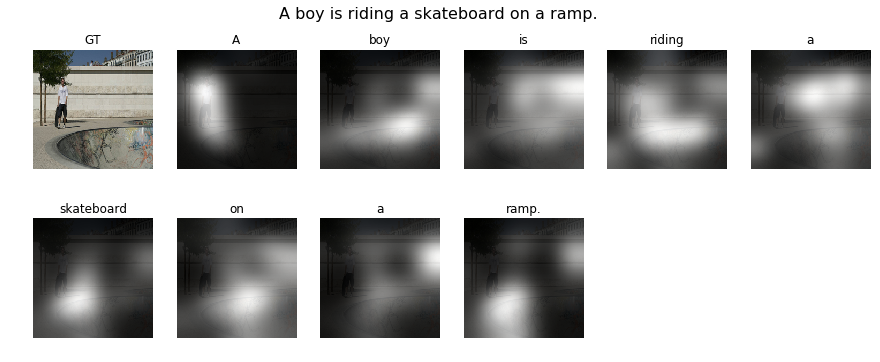

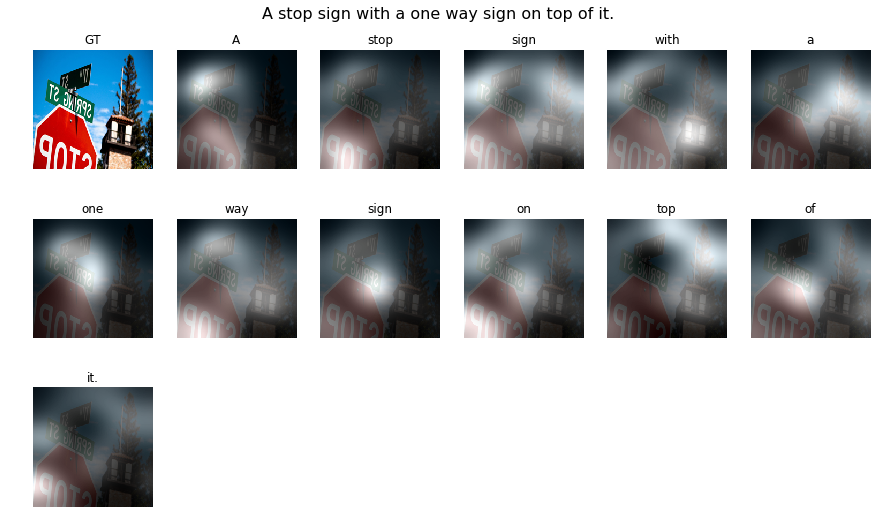

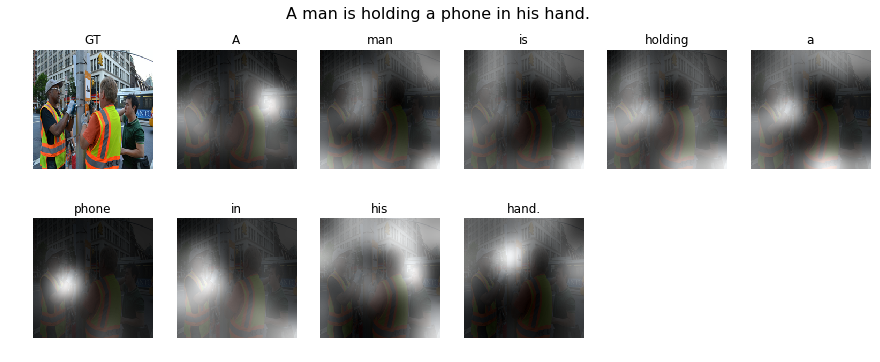

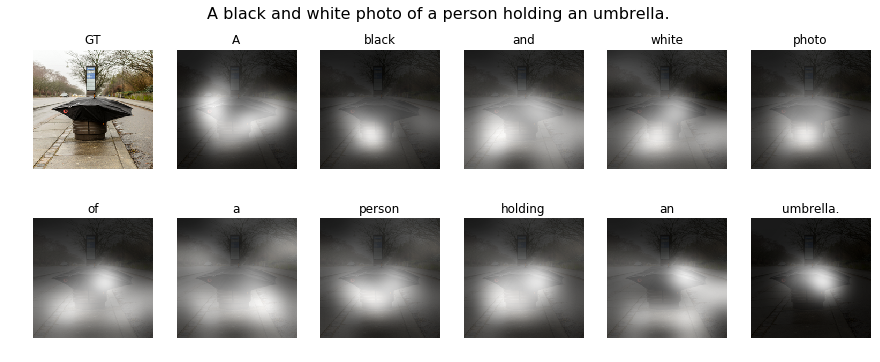

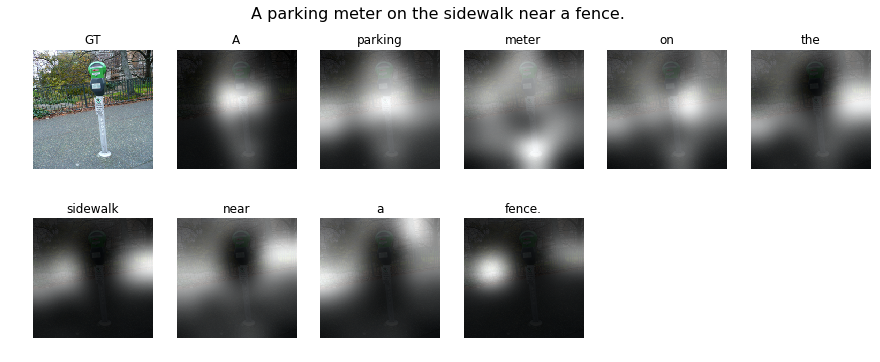

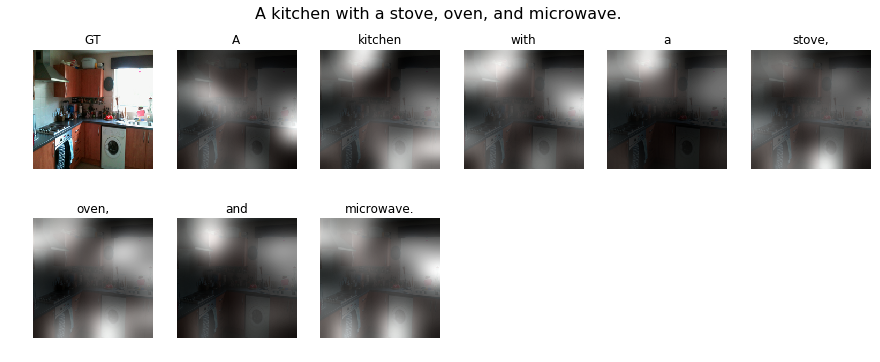

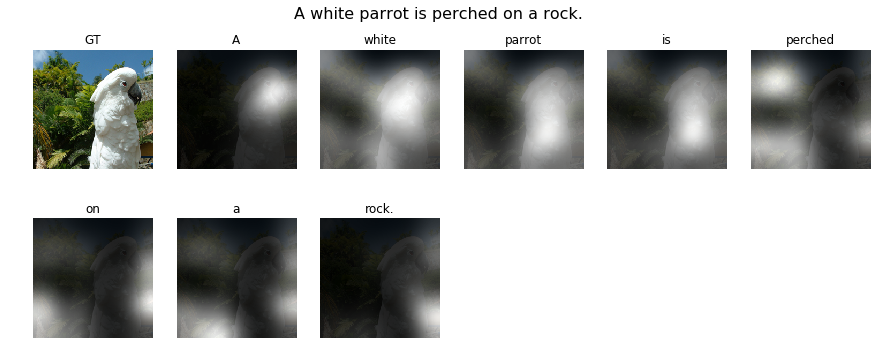

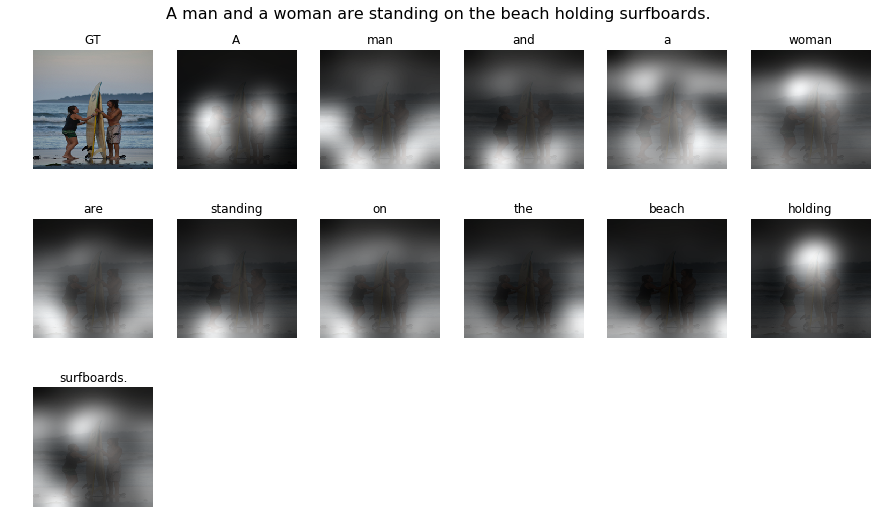

In [7]:
# visualize first batch
for im, pred, alpha in zip(image, preds, alphas):
    im = inverse_transform(im)
    sentence, words = dataset.indices_to_string(pred, True)
    
    fig = plt.figure(figsize=(15, 15))
    plt.suptitle(sentence, y=0.91, fontsize=16)

    plt.subplot(5, 6, 1)
    plt.imshow(im)
    plt.title("GT")
    plt.axis("off")
    
    for i, word in enumerate(words):
        if i+1 > 30: break

        mask = skimage.transform.pyramid_expand(
            alpha[i].reshape(14, 14), upscale=16, sigma=20)

        plt.subplot(5, 6, i+2)
        plt.imshow(im)
        plt.imshow(mask, cmap="gray", alpha=0.9)
        plt.title(word)
        plt.axis("off")